## gekoppelte Pendel

In [242]:
%pylab qt5
import os

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (11, 7)

import scipy.optimize

numpy.set_printoptions(linewidth=130)

Populating the interactive namespace from numpy and matplotlib


In [243]:
tt = []
xx1 = []; xx2 = []
TT = [];
for i in range(1, 4+1):
    txt = loadtxt(f'punkte_loch{i}_schwebung.txt', skiprows=5, delimiter='\t')
    t_, x1_, x2_ = transpose(txt)
    T_ = t_[-1]
    tt.append(t_)
    xx1.append(x1_); xx2.append(x2_)
    TT.append(T_)

vals = list(zip(tt, xx1, xx2, TT))

In [244]:
# wir werten die Schwebung für das dritte Loch aus
# ändert man die 3 kann man die anderen Schwebungen auswerten
t, x1, x2, TT = vals[2 - 1]

In [245]:
print(2*pi/t[-1])

0.0681843223785088


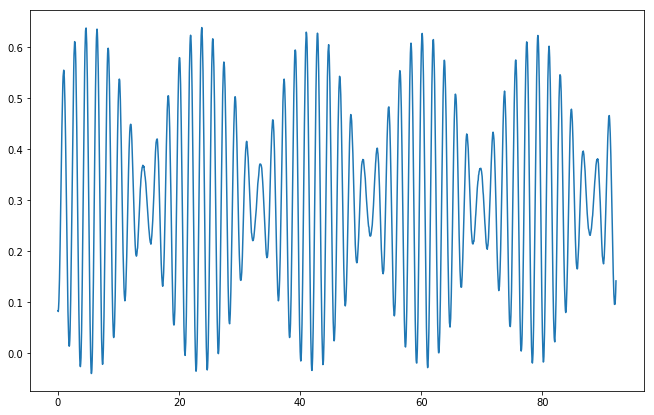

In [246]:
plt.plot(t, x1)

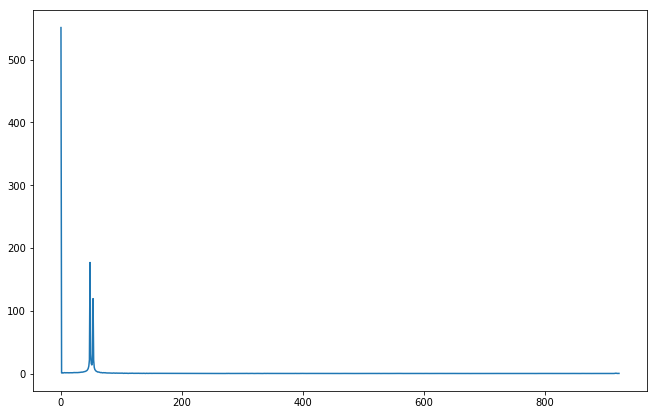

In [247]:
freq = fft.rfft(x1)
plt.plot(abs(freq))

In [248]:
n1, n2 = argpartition(-abs(freq), 2)[1:3]
print(n1, n2)

48 53


In [249]:
w1 = 2*pi/t[-1] * n1; w2 = 2*pi/t[-1] * n2
A1 = .9* sqrt(2*pi) * abs(freq[n1])/len(x1); phi1 = angle(freq[n1])
A2 = .9* sqrt(2*pi) * abs(freq[n2])/len(x1); phi2 = angle(freq[n2])

In [250]:
w1, A1, phi1
w2, A2, phi2
A = .5*(A1 + A2)

(3.2728474741684224, 0.21627428898371606, -2.0617726650207726)

(3.6137690860609664, 0.14585912984004418, 2.4373830918130044)

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


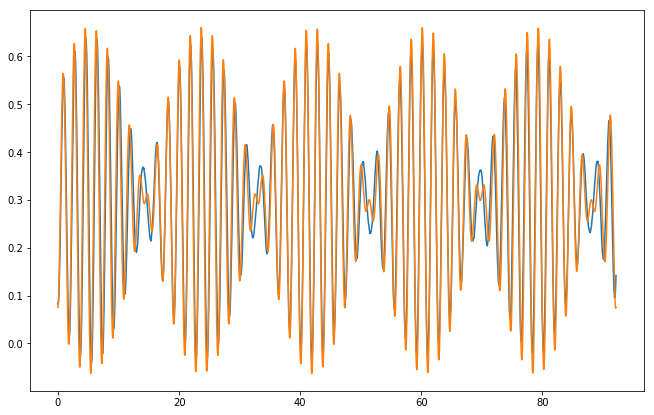

In [270]:
# _p1[0].remove(); _p2[0].remove()
_p1 = plt.plot(t, x1, 'C0')
_p2 = plt.plot(t, A * cos(w1*t + phi1) + A * cos(w2*t + phi2) + freq[0]/len(x1), 'C1')

In [252]:
2*pi/t[-1]

0.0681843223785088

In [253]:
def link(t, w1, w2, A1, A2, phi1, phi2):
    """Linearkombination von 2 Eigenmoden"""
    return A1*cos(w1*t + phi1) + A2*cos(w2*t + phi2)

def glink(t, w1, w2, A, phi1, phi2):
    """Schwebung als Linearkobination mit gleichem Koeffizient für beide Eigenmoden"""
    return A* (cos(w1*t + phi1) + cos(w2*t + phi2))

def linkd(t, w1, w2, A1, A2, phi1, phi2, g):
    """Linearkombination mit Dämpfung: exponentieller Abfall"""
    return (A1*cos(w1*t + phi1) + A2*cos(w2*t + phi2)) * exp(-g*t)

def linkd2(t, w1, w2, A1, A2, phi1, phi2, g):
    """Linearkombination mit Dämpfung: Dämpfung hängt von Geschwindigkeit ab
    (gedämpfter Oszillator)"""
    return A1*cos(w1*t + phi1)*exp(-g*w1*t) + A2*cos(w2*t + phi2)*exp(-g*w2*t)

def schweb(t, wi, wa, B, phii, phia):
    """Schwebung durch einhüllende Welle und schmelle Oszillation.
    Mathematisch äquivalent zu `glink`"""
    return B * cos(wa*t + phia) * cos(wi*t + phii)

In [254]:
a1 = x1 - mean(x1)

### fitten Schwebung direkt

In [255]:
wa = (w1 - w2)/2; wi = (w1 + w2)/2
p0 = [(w1 - w2)/2, (w1 + w2)/2, 2*A, (phi1 - phi2)/2, (phi1 + phi2)/2]
popt, pcov = scipy.optimize.curve_fit(schweb, t, a1, p0=p0,
                                      maxfev=300)

wi_, wa_, B_, phii_, phia_ = popt
err_wi, err_wa, err_B, err_phii, err_phia = sqrt(diag(pcov))
for v, err in zip(popt, sqrt(diag(pcov))):
    print(f'{v} +- {err}')
popt - p0

-0.17081852524940225 +- 0.00017478576576818945
3.451448604448479 +- 0.00017718807465388713
0.3320085309661066 +- 0.0015461582339335207
-2.239506917713402 +- 0.009737826665355425
-0.23643578926010111 +- 0.008961243578079661


array([-3.57719303e-04,  8.14032433e-03, -3.01248879e-02,  1.00709607e-02, -4.24241003e-01])

chi^2: 1.4242761956989487


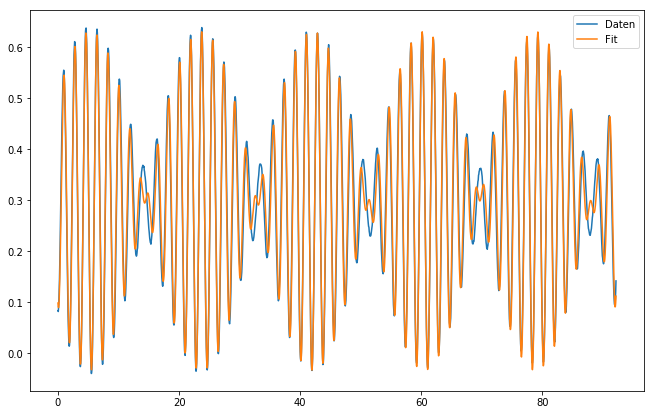

In [256]:
_ = plt.plot(t, x1)
fit = vectorize(schweb)(t, wi_, wa_, B_, phii_, phia_) + mean(x1)
_ = plt.plot(t, fit)
_ = plt.legend(['Daten', 'Fit'])
print('chi^2:', norm(x1 - fit))

### fitten Summe der Eigenmoden

In [257]:
popt, pcov = scipy.optimize.curve_fit(glink, t, a1, p0=[w1, w2, A, phi1, phi2],
                                      maxfev=200)
w1_, w2_, A_, phi1_, phi2_ = popt
err_w1, err_w2, err_A, err_phi1, err_phi2 = sqrt(diag(pcov))
for v, err in zip(popt, sqrt(diag(pcov))):
    print(f'{v} +- {err}')
popt - [w1, w2, A, phi1, phi2]

3.280630061746123 +- 0.0002486373937458866
3.6222671585842257 +- 0.0002491405813058029
0.1660042675937767 +- 0.0007730791315505137
-2.4759418325918325 +- 0.013204800900142203
2.003069770223617 +- 0.013262410922573548


array([ 0.00778259,  0.00849807, -0.01506244, -0.41416917, -0.43431332])

chi^2: 1.424276195646343


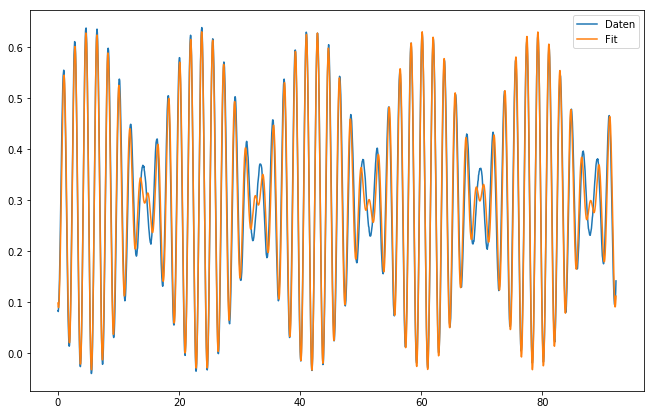

In [258]:
_ = plt.plot(t, x1)
fit = vectorize(glink)(t, w1_, w2_, A_, phi1_, phi2_) + mean(x1)
_ = plt.plot(t, vectorize(glink)(t, w1_, w2_, A_, phi1_, phi2_) + mean(x1))
_ = plt.legend(['Daten', 'Fit'])
print('chi^2:', norm(x1 - fit))

### fitten linearkombination der Eigenmoden

In [259]:
popt, pcov = scipy.optimize.curve_fit(link, t, a1, p0=[w1, w2, A1, A2, phi1, phi2],
                                      maxfev=100)
w1_, w2_, A1_, A2_, phi1_, phi2_ = popt
err_w1, err_w2, err_A1, err_A2, err_phi1, err_phi2 = sqrt(diag(pcov))
for v, err in zip(popt, sqrt(diag(pcov))):
    print(f'{v} +- {err}')
popt - [w1, w2, A1, A2, phi1, phi2]

3.2807995355933146 +- 2.5473508217948118e-05
3.6224482061591567 +- 3.817080318708441e-05
0.19898925672061163 +- 0.000134413997404224
0.13305849696752234 +- 0.00013433916565318944
-2.483462785969504 +- 0.0013528296678954309
1.9957006075371517 +- 0.002031778511055498


array([ 0.00795206,  0.00867912, -0.01728503, -0.01280063, -0.42169012, -0.44168248])

chi^2: 0.17484015468022382


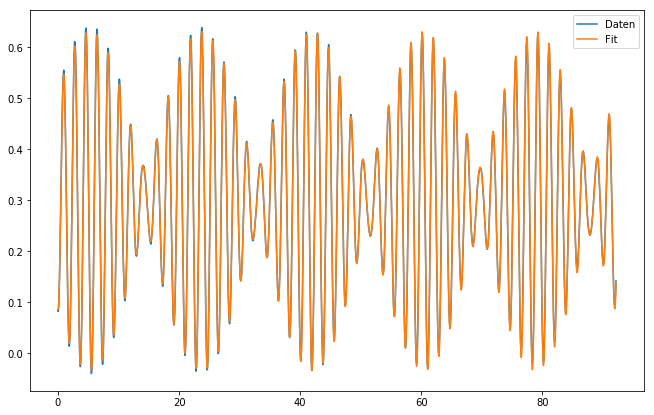

In [260]:
_ = plt.plot(t, x1)
fit = vectorize(link)(t, w1_, w2_, A1_, A2_, phi1_, phi2_) + mean(x1)
_ = plt.plot(t, fit)
_ = plt.legend(['Daten', 'Fit'])
print('chi^2:', norm(x1 - fit))

### because we can: Linearkombination mit Dämpfung

3.2807766867169 +- 1.34e-05
3.6224884985113 +- 2.02e-05
0.20587862029022 +- 0.000124
0.13740945261274 +- 9.63e-05
-2.4820453207025 +- 0.000701
1.9931990767084 +- 0.00106
0.00077370405205311 +- 1.12e-05

Differenzen: [ 0.00792921  0.00871941 -0.01039567 -0.00844968 -0.42027266 -0.44418402 -0.9992263 ]

chi^2: 0.09201556569893221


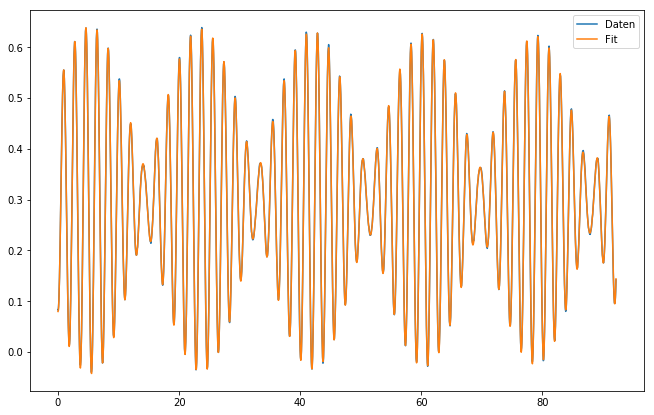

In [264]:
popt, pcov = scipy.optimize.curve_fit(linkd, t, a1, p0=[w1, w2, A1, A2, phi1, phi2, 0],
                                      maxfev=100)
w1_, w2_, A1_, A2_, phi1_, phi2_, g_ = popt
err_w1, err_w2, err_A1, err_A2, err_phi1, err_phi2, err_g = sqrt(diag(pcov))
for v, err in zip(popt, sqrt(diag(pcov))):
    print(f'{v:.14} +- {err:.3}')
print()
print('Differenzen:', popt - [w1, w2, A1, A2, phi1, phi2, 1])

_ = plt.plot(t, x1)
fit = vectorize(linkd)(t, w1_, w2_, A1_, A2_, phi1_, phi2_, g_) + mean(x1)
_ = plt.plot(t, fit)
_ = plt.legend(['Daten', 'Fit'])
print()
print('chi^2:', norm(x1 - fit))

In [262]:
(w2_ - w1_)/2
sqrt([.5, -.5] @ pcov[0:2, 0:2] @ [.5, -.5])

0.17085590589718413

1.2067476981430318e-05